In [1]:
import torch.nn.functional as F
import itertools, imageio, torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.font_manager as font_manager
import numpy as np
import os
import time
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import tqdm

from torchvision import transforms
from torch.autograd import Variable
from torchvision import datasets
from scipy.misc import imresize
from IPython.display import Image
from torchsummary import summary

In [2]:
warnings.filterwarnings('ignore')

# Часть первая: перенос стиля при помощи pix2pix

## Вспомогательные функции

In [19]:
def show_result(G, x_, y_, num_epoch, show=False, save=False, path='result.png'):
    test_images = G(x_)
    size_figure_grid = 3
    fig, ax = plt.subplots(x_.size()[0],
                           size_figure_grid,
                           figsize=(10, 10),
                          )
    for i, j in itertools.product(range(x_.size()[0]), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
    for i in range(x_.size()[0]):
        ax[i, 0].cla()
        ax[i, 0].imshow((x_[i].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)
        ax[i, 1].cla()
        ax[i, 1].imshow((test_images[i].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)
        ax[i, 2].cla()
        ax[i, 2].imshow((y_[i].numpy().transpose(1, 2, 0) + 1) / 2)
    font_prop = font_manager.FontProperties(size=14)
    label = 'Train epoch {0}'.format(num_epoch)
    fig.text(0.5,
             0.04,
             label,
             ha='center',
             fontproperties=font_prop,
            )
    if save:
        plt.savefig(path)
    if show:
        plt.show()
    else:
        plt.close()

        
def show_train_hist(hist, show=True, save=True, path='Train_hist.png', is_gen_log=False):
    x = range(len(hist['D_losses']))
    y1 = hist['D_losses']
    if is_gen_log:
        y2 = np.log(np.array(hist['G_losses']))
        label_g = 'Generator loss (ln)'
    else:
        y2 = hist['G_losses']
        label_g = 'Generator loss'
    plt.figure(figsize=(10, 6))
    plt.title('Generator and Discriminator loss', fontsize=16)
    plt.plot(x,
             y1,
             'g',
             label='Discriminator loss',
            )
    plt.plot(x,
             y2,
             'r',
             label=label_g,
            )
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    if save:
        plt.savefig(path)
    if show:
        plt.show()
    else:
        plt.close()

        
def generate_animation(root, model, is_show=True):
    images = []
    for e in range(train_epoch):
        img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(root + model + 'generate_animation.gif', images, fps=5)
    if is_show:
        with open(root + model + 'generate_animation.gif','rb') as file:
            display(Image(file.read()))

    
def data_load(path, subfolder, transform, batch_size, shuffle=True):
    dset = datasets.ImageFolder(path, transform)
    ind = dset.class_to_idx[subfolder]
    n = 0
    for i in range(dset.__len__()):
        if ind != dset.imgs[n][1]:
            del dset.imgs[n]
            n -= 1
        n += 1
    return torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=shuffle)


def imgs_resize(imgs, resize_scale=286):
    outputs = torch.FloatTensor(imgs.size()[0], imgs.size()[1], resize_scale, resize_scale)
    for i in range(imgs.size()[0]):
        img = imresize(imgs[i].numpy(), [resize_scale, resize_scale])
        outputs[i] = torch.FloatTensor((img.transpose(2, 0, 1).astype(np.float32).reshape(-1,
                                                                                          imgs.size()[1],
                                                                                          resize_scale,
                                                                                          resize_scale,
                                                                                         ) - 127.5) / 127.5)
    return outputs


def random_crop(imgs1, imgs2, crop_size=256):
    outputs1 = torch.FloatTensor(imgs1.size()[0], imgs1.size()[1], crop_size, crop_size)
    outputs2 = torch.FloatTensor(imgs2.size()[0], imgs2.size()[1], crop_size, crop_size)
    for i in range(imgs1.size()[0]):
        img1 = imgs1[i]
        img2 = imgs2[i]
        rand1 = np.random.randint(0, imgs1.size()[2] - crop_size)
        rand2 = np.random.randint(0, imgs2.size()[2] - crop_size)
        outputs1[i] = img1[:, rand1: crop_size + rand1, rand2: crop_size + rand2]
        outputs2[i] = img2[:, rand1: crop_size + rand1, rand2: crop_size + rand2]
    return outputs1, outputs2


def random_fliplr(imgs1, imgs2):
    outputs1 = torch.FloatTensor(imgs1.size())
    outputs2 = torch.FloatTensor(imgs2.size())
    for i in range(imgs1.size()[0]):
        if torch.rand(1)[0] < 0.5:
            img1 = torch.FloatTensor(
                (np.fliplr(imgs1[i].numpy().transpose(1, 2, 0)).transpose(2, 0, 1).reshape(-1,
                                                                                           imgs1.size()[1],
                                                                                           imgs1.size()[2],
                                                                                           imgs1.size()[3],
                                                                                          ) + 1) / 2)
            outputs1[i] = (img1 - 0.5) / 0.5
            img2 = torch.FloatTensor(
                (np.fliplr(imgs2[i].numpy().transpose(1, 2, 0)).transpose(2, 0, 1).reshape(-1,
                                                                                           imgs2.size()[1],
                                                                                           imgs2.size()[2],
                                                                                           imgs2.size()[3],
                                                                                          ) + 1) / 2)
            outputs2[i] = (img2 - 0.5) / 0.5
        else:
            outputs1[i] = imgs1[i]
            outputs2[i] = imgs2[i]
    return outputs1, outputs2

## Реализация GAN

In [4]:
class Generator(nn.Module):
    def __init__(self, d=64):
        super(Generator, self).__init__()
        # Unet encoder
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d * 8)
        self.conv6 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(d * 8)
        self.conv7 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(d * 8)
        self.conv8 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        
        # Unet decoder
        self.deconv1 = nn.ConvTranspose2d(d * 8, d * 8, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 8)
        self.deconv3 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 8)
        self.deconv4 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d * 8)
        self.deconv5 = nn.ConvTranspose2d(d * 8 * 2, d * 4, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d * 4)
        self.deconv6 = nn.ConvTranspose2d(d * 4 * 2, d * 2, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(d * 2)
        self.deconv7 = nn.ConvTranspose2d(d * 2 * 2, d, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(d)
        self.deconv8 = nn.ConvTranspose2d(d * 2, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        e1 = self.conv1(input)
        e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
        e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
        e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
        e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
        e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
        e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
        e8 = self.conv8(F.leaky_relu(e7, 0.2))
        d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e8))), 0.5, training=True)
        d1 = torch.cat([d1, e7], 1)
        d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
        d2 = torch.cat([d2, e6], 1)
        d3 = F.dropout(self.deconv3_bn(self.deconv3(F.relu(d2))), 0.5, training=True)
        d3 = torch.cat([d3, e5], 1)
        d4 = self.deconv4_bn(self.deconv4(F.relu(d3)))
        d4 = torch.cat([d4, e4], 1)
        d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
        d5 = torch.cat([d5, e3], 1)
        d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
        d6 = torch.cat([d6, e2], 1)
        d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
        d7 = torch.cat([d7, e1], 1)
        d8 = self.deconv8(F.relu(d7))
        o = F.tanh(d8)
        return o

class Discriminator(nn.Module):
    def __init__(self, d=64):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(6, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))
        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

## Параметры

In [15]:
dataset, save_root, train_subfolder, test_subfolder, = 'facades', 'results', 'train', 'val'
inverse_order = True
fliplr = True
batch_size, test_batch_size = 1, 5
ngf, ndf = 64, 64
input_size, crop_size, resize_scale = 256, 256, 286
train_epoch = 200
lrD, lrG, L1_lambda = 3e-4, 3e-4, 100
beta1, beta2 = 0.5, 0.9

In [6]:
root = dataset + '_' + save_root + '/'
model = dataset + '_'

if not os.path.isdir(root):
    os.mkdir(root) 
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

In [7]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                               ],
                              )

train_loader = data_load(dataset,
                         train_subfolder,
                         transform,
                         batch_size,
                         shuffle=True,
                        )

test_loader = data_load(dataset,
                        test_subfolder,
                        transform,
                        test_batch_size,
                        shuffle=False,
                       )

test = test_loader.__iter__().__next__()[0]
img_size = test.size()[2]

if inverse_order:
    fixed_y_ = test[:, :, :, 0:img_size]
    fixed_x_ = test[:, :, :, img_size:]
else:
    fixed_x_ = test[:, :, :, 0:img_size]
    fixed_y_ = test[:, :, :, img_size:]

if img_size != input_size:
    fixed_x_ = imgs_resize(fixed_x_, input_size)
    fixed_y_ = imgs_resize(fixed_y_, input_size)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:',
          round(torch.cuda.memory_allocated(0) / 1024**3, 1),
          'GB',
         )
    print('Cached:   ',
          round(torch.cuda.memory_reserved(0) / 1024**3, 1),
          'GB',
         )

Using device: cuda

GeForce RTX 2060
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Структура GAN

In [10]:
G = Generator(ngf)
G.weight_init(mean=0.0, std=0.02)
G.to(device)
G.train();
summary(G,
        input_size=(3,
                    input_size,
                    input_size,
                   ),
       )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 16, 16]       2,097,664
       BatchNorm2d-7          [-1, 512, 16, 16]           1,024
            Conv2d-8            [-1, 512, 8, 8]       4,194,816
       BatchNorm2d-9            [-1, 512, 8, 8]           1,024
           Conv2d-10            [-1, 512, 4, 4]       4,194,816
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
           Conv2d-12            [-1, 512, 2, 2]       4,194,816
      BatchNorm2d-13            [-1, 512, 2, 2]           1,024
           Conv2d-14            [-1, 51

In [11]:
D = Discriminator(ndf)
D.weight_init(mean=0.0, std=0.02)
D.to(device)
D.train()

Discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

In [12]:
BCE_loss = nn.BCELoss().to(device)
L1_loss = nn.L1Loss().to(device)
G_optimizer = optim.Adam(G.parameters(),
                         lr=lrG,
                         betas=(beta1, beta2),
                        )
D_optimizer = optim.Adam(D.parameters(),
                         lr=lrD,
                         betas=(beta1, beta2),
                        )

## Обучение GAN

In [13]:
train_hist = {}

train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

In [16]:
print('Training start!')

start_time = time.time()

for epoch in tqdm.tqdm_notebook(range(train_epoch)):
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    num_iter = 0
    for x_, _ in train_loader:
        D.zero_grad()
        if inverse_order:
            y_ = x_[:, :, :, 0:img_size]
            x_ = x_[:, :, :, img_size:]
        else:
            y_ = x_[:, :, :, img_size:]
            x_ = x_[:, :, :, 0:img_size]            
        if img_size != input_size:
            x_ = imgs_resize(x_, input_size)
            y_ = imgs_resize(y_, input_size)
        if resize_scale:
            x_ = imgs_resize(x_, resize_scale)
            y_ = imgs_resize(y_, resize_scale)
        if crop_size:
            x_, y_ = random_crop(x_, y_, crop_size)
        if fliplr:
            x_, y_ = random_fliplr(x_, y_)
        x_, y_ = Variable(x_.to(device)), Variable(y_.to(device))
        D_result = D(x_, y_).squeeze()
        D_real_loss = BCE_loss(D_result, Variable(torch.ones(D_result.size()).to(device)))
        G_result = G(x_)
        D_result = D(x_, G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, Variable(torch.zeros(D_result.size()).to(device)))
        D_train_loss = (D_real_loss + D_fake_loss) * 0.5
        D_train_loss.backward()
        D_optimizer.step()
        train_hist['D_losses'].append(D_train_loss.data)
        D_losses.append(D_train_loss.data)
        G.zero_grad()
        G_result = G(x_)
        D_result = D(x_, G_result).squeeze()
        G_train_loss = BCE_loss(D_result, Variable(torch.ones(D_result.size()).to(device))) + L1_lambda * L1_loss(G_result, y_)
        G_train_loss.backward()
        G_optimizer.step()
        train_hist['G_losses'].append(G_train_loss.data)
        G_losses.append(G_train_loss.data)
        num_iter += 1

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time   
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'    
    show_result(G,
                Variable(fixed_x_.to(device), volatile=True),
                fixed_y_,
                (epoch + 1),
                save=True,
                path=fixed_p,
               )    
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)
    
    print('Epoch [%d/%d] | epoch time, s: %.2f | dis_loss: %.3f | gen_loss: %.3f' % ((epoch + 1),
                                                                                     train_epoch,
                                                                                     per_epoch_ptime,
                                                                                     torch.mean(torch.FloatTensor(D_losses)),
                                                                                     torch.mean(torch.FloatTensor(G_losses)),
                                                                                     ),
     )

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print('Training finish!')
print('Mean epoch time: %.2f s, all epochs time: %.2f s' % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])),
                                                            total_ptime),
     )

Training start!


Epoch [1/200] | epoch time, s: 21.72 | dis_loss: 0.450 | gen_loss: 36.648
Epoch [2/200] | epoch time, s: 20.93 | dis_loss: 0.263 | gen_loss: 37.826
Epoch [3/200] | epoch time, s: 20.99 | dis_loss: 0.325 | gen_loss: 38.215
Epoch [4/200] | epoch time, s: 21.06 | dis_loss: 0.342 | gen_loss: 38.216
Epoch [5/200] | epoch time, s: 21.13 | dis_loss: 0.333 | gen_loss: 38.103
Epoch [6/200] | epoch time, s: 21.27 | dis_loss: 0.345 | gen_loss: 37.592
Epoch [7/200] | epoch time, s: 21.28 | dis_loss: 0.362 | gen_loss: 37.975
Epoch [8/200] | epoch time, s: 21.33 | dis_loss: 0.362 | gen_loss: 38.096
Epoch [9/200] | epoch time, s: 21.43 | dis_loss: 0.380 | gen_loss: 37.919
Epoch [10/200] | epoch time, s: 21.03 | dis_loss: 0.380 | gen_loss: 37.733
Epoch [11/200] | epoch time, s: 21.41 | dis_loss: 0.383 | gen_loss: 37.426
Epoch [12/200] | epoch time, s: 21.10 | dis_loss: 0.388 | gen_loss: 37.570
Epoch [13/200] | epoch time, s: 21.50 | dis_loss: 0.387 | gen_loss: 37.269
Epoch [14/200] | epoch time, s: 21

In [17]:
torch.save(G.state_dict(), root + model + 'generator_param.pkl')
torch.save(D.state_dict(), root + model + 'discriminator_param.pkl')

In [18]:
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

## Результаты обучения

### Лоссы генератора и дискриминатора

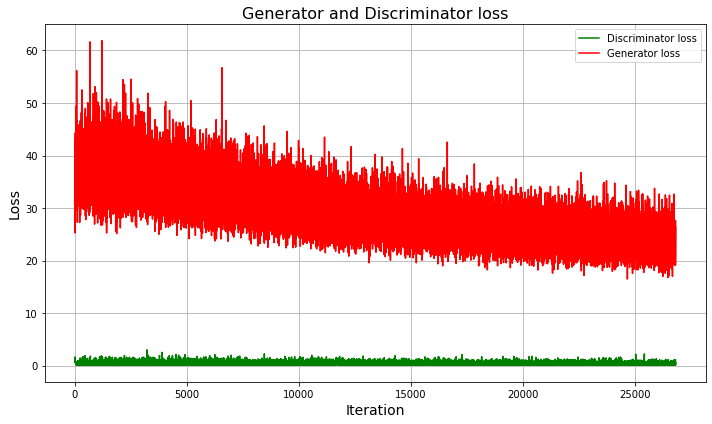

In [22]:
show_train_hist(train_hist, is_gen_log=False)

## Тестирование обученной GAN

In [24]:
if not os.path.isdir(dataset + '_results/test_results'):
    os.mkdir(dataset + '_results/test_results')

In [25]:
G = Generator(ngf)
G.to(device)
G.load_state_dict(torch.load(dataset + '_results/' + dataset + '_generator_param.pkl'))

<All keys matched successfully>

In [26]:
n = 0

print('Testing start!')

for x_, _ in test_loader:
    if inverse_order:
        y_ = x_[:, :, :, :x_.size()[2]]
        x_ = x_[:, :, :, x_.size()[2]:]
    else:
        y_ = x_[:, :, :, x_.size()[2]:]
        x_ = x_[:, :, :, :x_.size()[2]]
    if x_.size()[2] != input_size:
        x_ = util.imgs_resize(x_, input_size)
        y_ = util.imgs_resize(y_, input_size)
    x_ = Variable(x_.to(device), volatile=True)
    test_image = G(x_)
    s = test_loader.dataset.imgs[n][0][::-1]
    s_ind = len(s) - s.find('/')
    e_ind = len(s) - s.find('.')
    ind = test_loader.dataset.imgs[n][0][s_ind:e_ind-1]
    path = dataset + '_results/test_results/' + ind + '_input.png'
    plt.imsave(path, (x_[0].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)
    path = dataset + '_results/test_results/' + ind + '_output.png'
    plt.imsave(path, (test_image[0].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)
    path = dataset + '_results/test_results/' + ind + '_target.png'
    plt.imsave(path, (y_[0].numpy().transpose(1, 2, 0) + 1) / 2)
    n += 1

print('%d images generation complete!' % n)

Testing start!
20 images generation complete!


### Результат работы на тестовых данных 

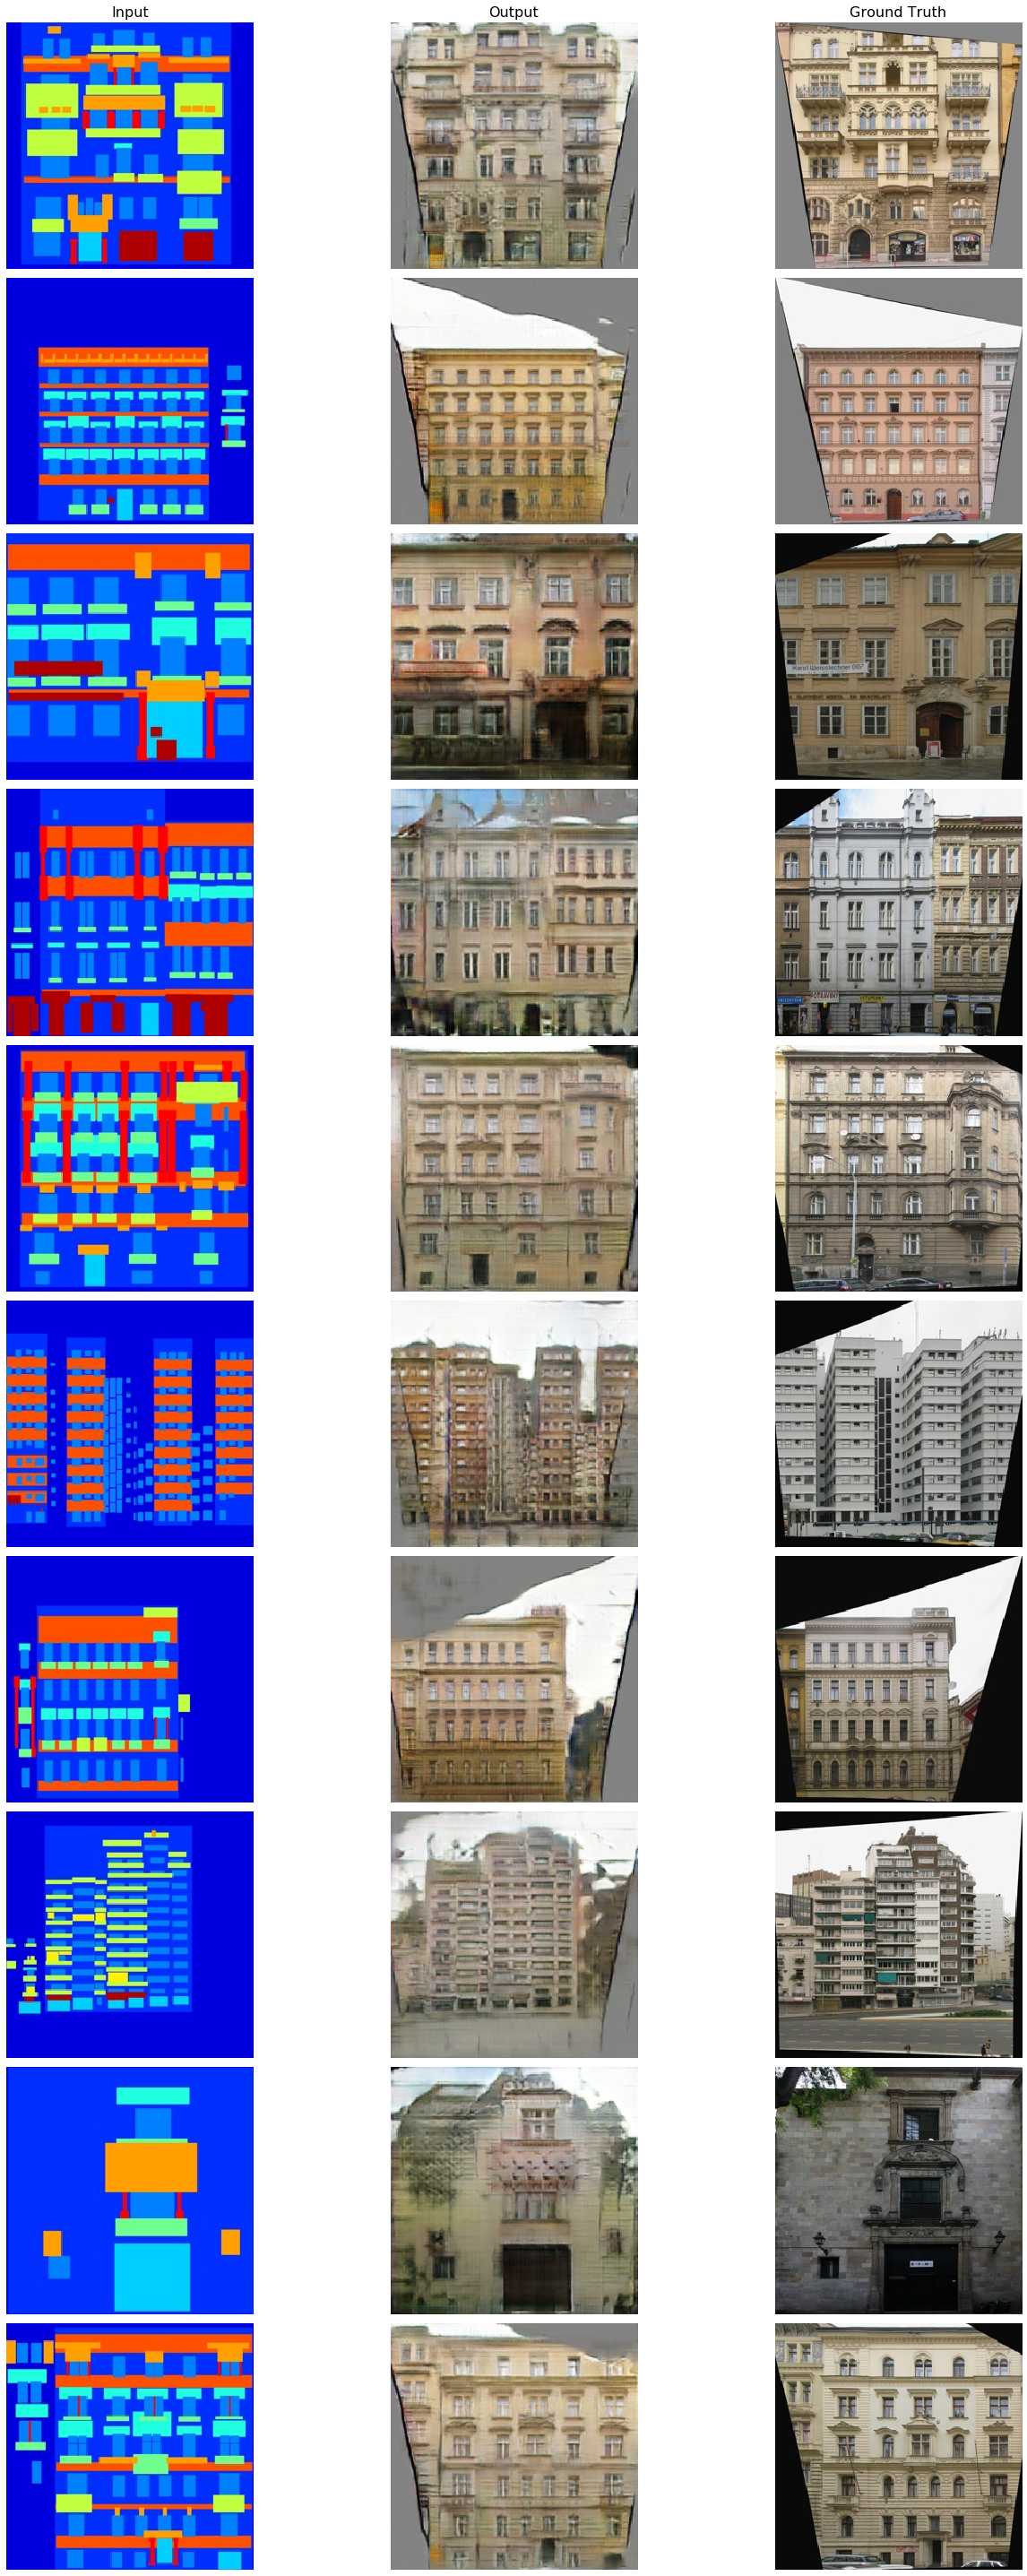

In [27]:
n_pic = 10

curr_dir = os.path.abspath(os.getcwd())
img_list = sorted(os.listdir(os.path.join(curr_dir, 'facades_results/test_results')))[0:n_pic * 3]
nrows = n_pic
ncols = 3
figsize = (n_pic * 2, n_pic * 4)
cols = ['Input', 'Output', 'Ground Truth']
rows = ['Test picture {}'.format(row) for row in list(range(1, n_pic + 1))]
fig, ax = plt.subplots(nrows=nrows,
                       ncols=ncols,
                       figsize=figsize,
                       )
for i, axi in enumerate(ax.flat):
    img = plt.imread('facades_results/test_results/' + img_list[i])
    axi.imshow(img)
    axi.axis('off')
for ax, col in zip(ax[0], cols):
    ax.set_title(col, fontdict={'fontsize': 16})
plt.tight_layout(True)
plt.show()